In [77]:
import numpy as np
from scipy.stats import beta
import matplotlib.pyplot as plt

## Our Technique

1. Exploration Phase (First 10 Days) → Each treatment is tested at least once.
2. Exploitation Phase (After 10 Days) → Treatments are selected based on success count weighting.
3. Treatment Elimination → If a treatment fails 3 times, it is permanently removed (unless it's the last option).
4. Selection Rule → Treatments with more successes are chosen more frequently.
5. Stopping Criteria → Runs for 100 days, optimizing toward the best treatments.
6. Visualization 

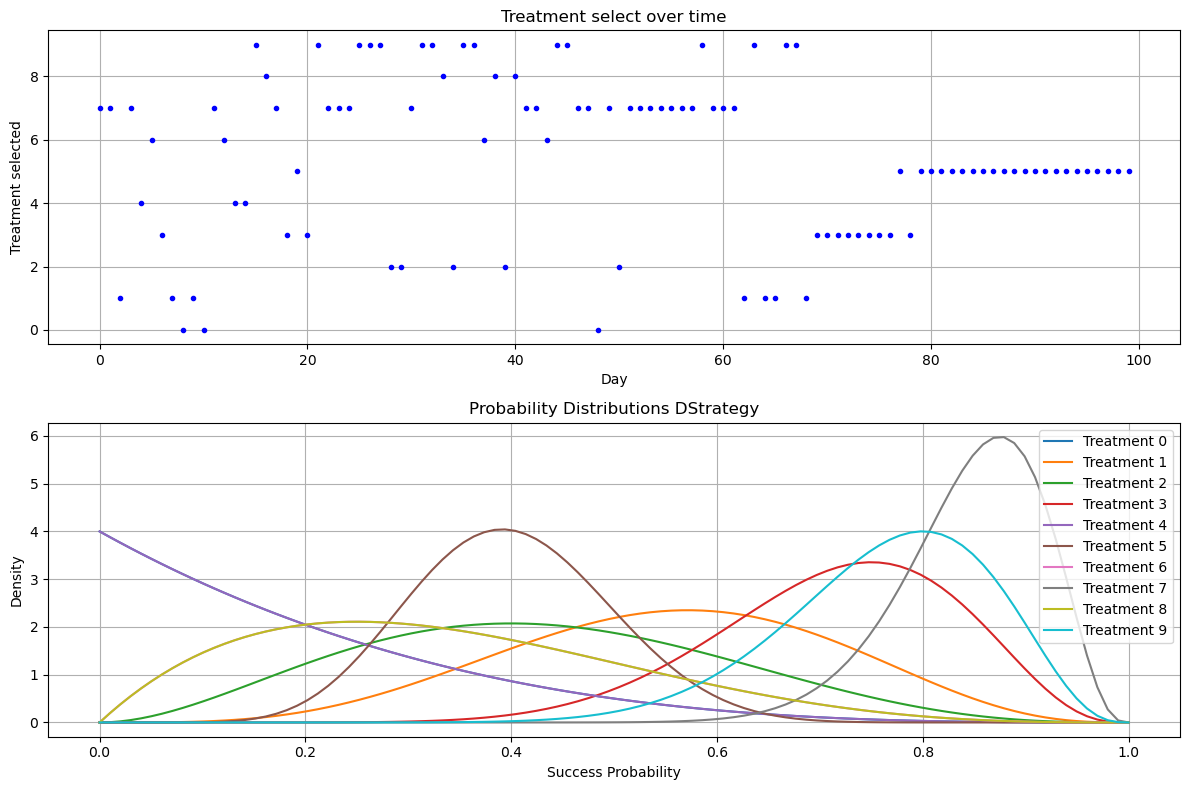

In [78]:

class DStrategy:
    def __init__(self, n_treatments=10, n_days=100, patience_threshold=3):
        self.n_treatments = n_treatments
        self.n_days = n_days
        self.patience_threshold = patience_threshold

        # Track success/failure counts
        self.success_counts = np.zeros(n_treatments)
        self.failure_counts = np.zeros(n_treatments)
        self.available_treatments = set(range(n_treatments))
        
        # Track history
        self.choices = []
        self.rewards = []
        self.cumulative_rewards = []

    def select_treatment(self):
        """Weighted selection: favor treatments with higher success rates."""
        if not self.available_treatments:
            self.available_treatments = set(range(self.n_treatments))  # Reset if all are eliminated
        
        weights = [self.success_counts[i] + 1 for i in self.available_treatments] 
        return list(self.available_treatments)[np.random.choice(len(weights), p=np.array(weights)/sum(weights))]

    def update(self, treatment, reward):
        self.success_counts[treatment] += reward
        self.failure_counts[treatment] += (1 - reward)

        # Track history
        self.choices.append(treatment)
        self.rewards.append(reward)
        self.cumulative_rewards.append(sum(self.rewards))

        # Eliminate treatment if it fails too many times
        if self.failure_counts[treatment] >= self.patience_threshold and len(self.available_treatments) > 1:
            self.available_treatments.discard(treatment)

    def run_simulation(self, true_probabilities):
        for _ in range(self.n_days):
            treatment = self.select_treatment()
            reward = np.random.binomial(1, true_probabilities[treatment])
            self.update(treatment, reward)

    def plot_results(self):
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

        # Plot chosen treatments over time
        ax1.plot(self.choices, 'b.')
        ax1.set_xlabel('Day')
        ax1.set_ylabel('Treatment selected')
        ax1.set_title('Treatment select over time')
        ax1.grid(True)

        # Plot the distributions
        x = np.linspace(0, 1, 100)
        for i in range(self.n_treatments):
            alpha = self.success_counts[i] + 1
            beta_val = self.failure_counts[i] + 1
            y = beta.pdf(x, alpha, beta_val)
            ax2.plot(x, y, label=f'Treatment {i}')
        
        ax2.set_xlabel('Success Probability')
        ax2.set_ylabel('Density')
        ax2.set_title('Probability Distributions DStrategy')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        plt.show()

# Example Run
true_probabilities = np.array([0.1, 0.3, 0.5, 0.7, 0.2, 0.4, 0.6, 0.8, 0.25, 0.55])
greedy = DStrategy(n_treatments=10, n_days=100, patience_threshold=3)
greedy.run_simulation(true_probabilities)
greedy.plot_results()


We print the number of times each treatments have been used

In [79]:
unique, counts = np.unique(greedy.choices, return_counts=True)
for treatment, count in zip(unique, counts):
    print(f"Treatment {treatment}: {count} times")

Treatment 0: 3 times
Treatment 1: 7 times
Treatment 2: 5 times
Treatment 3: 12 times
Treatment 4: 3 times
Treatment 5: 23 times
Treatment 6: 4 times
Treatment 7: 24 times
Treatment 8: 4 times
Treatment 9: 15 times


## Beta Distribution

ThompsonSAmpling class with beta distribution parameters for each treatments.
- select_treatment(): samples from each treatment's Beta distribution and selects the highest value
- update(): updates the beta parameters based on observeed treatment
- run_simulation(): runs the 100 day experiment

In [80]:
class ThompsonSampling:
    def __init__(self, n_treatments=10, n_days=100):
        self.n_treatments = n_treatments
        self.n_days = n_days
        
        #initialize Beta distribution parameters for each treatment
        self.alphas = np.ones(n_treatments)
        self.betas = np.ones(n_treatments)
        
        #track history
        self.choices = []
        self.rewards = []
        self.cumulative_rewards = []
        
    #select the best treatment for each experiment    
    def select_treatment(self):
        samples = [beta.rvs(a, b) for a, b in zip(self.alphas, self.betas)]
        return np.argmax(samples)
    
    #update beta distribution based on reward
    def update(self, treatment, reward):
        self.alphas[treatment] += reward
        self.betas[treatment] += (1 - reward)
        
        #track history
        self.choices.append(treatment)
        self.rewards.append(reward)
        self.cumulative_rewards.append(sum(self.rewards))
    
    def run_simulation(self, true_probabilities):
        for _ in range(self.n_days):
            treatment = self.select_treatment()
            #generate reward based on true probability
            reward = np.random.binomial(1, true_probabilities[treatment])
            self.update(treatment, reward)
    
    #more plots can be added
    def plot_results(self):
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
        
        ax1.plot(self.choices, 'b.')
        ax1.set_xlabel('Day')
        ax1.set_ylabel('Treatment selected')
        ax1.set_title('Treatment select over time')
        ax1.grid(True)
        
        x = np.linspace(0, 1, 100)
        for i in range(self.n_treatments):
            y = beta.pdf(x, self.alphas[i], self.betas[i])
            ax2.plot(x, y, label=f'Treatment {i}')
        ax2.set_xlabel('Success Probability')
        ax2.set_ylabel('Density')
        ax2.set_title('Final Beta Distributions')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        plt.show()

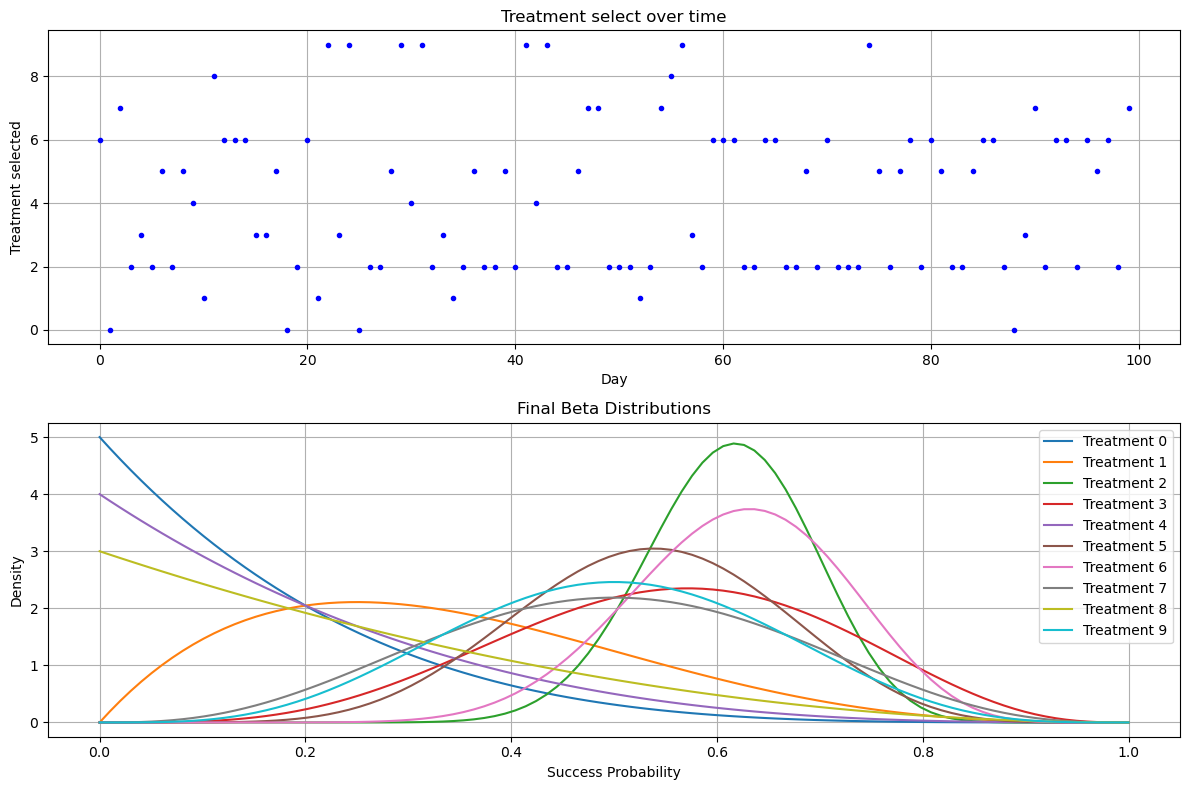

In [81]:
#arbitrarily set probabilities for each treatment
true_probabilities = np.array([0.1, 0.3, 0.5, 0.7, 0.2, 0.4, 0.6, 0.8, 0.25, 0.55])

ts = ThompsonSampling()
ts.run_simulation(true_probabilities)
ts.plot_results()

We print the number of times each treatments have been used

In [82]:
unique, counts = np.unique(ts.choices, return_counts=True)
for treatment, count in zip(unique, counts):
    print(f"Treatment {treatment}: {count} times")

Treatment 0: 4 times
Treatment 1: 4 times
Treatment 2: 34 times
Treatment 3: 7 times
Treatment 4: 3 times
Treatment 5: 13 times
Treatment 6: 19 times
Treatment 7: 6 times
Treatment 8: 2 times
Treatment 9: 8 times
